## EXOD Detector MOS

Import

In [303]:
import sys
import os
import time
import shutil
from functools import partial
from datetime import datetime, date

# Third-party imports

from math import *
from multiprocessing import Pool
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import argparse
import matplotlib
matplotlib.use("Pdf")
from matplotlib import colors, image, transforms, gridspec
import matplotlib.pyplot as plt
from pylab import figure, cm

# Internal imports

from fits_extractor import *
from variability_utils import *
import file_names as FileNames
from file_utils import *
from renderer import *
from exodus_utils import *

Arguments

In [79]:
path = '/home/monrillo/data/0744350301/'
evts = path + 'PN_clean.fits'
img  = path + 'PN_image.fits'
gti  = path + 'PN_gti.fits'
out  = path + '8_300_5_1.0_PN/'
obs  = '0744350301'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'PN'
ol   = path + 'log.txt'
ccdnb = 12

In [329]:
path = '/home/monrillo/data/0505720201/'
evts = path + 'M1_clean.fits'
img  = path + 'M1_image.fits'
gti  = path + 'M1_gti.fits'
out  = path + '8_300_5_1.0_M1/'
obs  = '0505720201'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'M1'
ol   = path + 'log.txt'
ccdnb = 7

In [382]:
path = '/home/monrillo/data/0505720201/'
evts = path + 'M2_clean.fits'
img  = path + 'M2_image.fits'
gti  = path + 'M2_gti.fits'
out  = path + '8_300_5_1.0_M2/'
obs  = '0505720201'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'M2'
ol   = path + 'log.txt'
ccdnb = 7

Preliminaries

In [383]:
# Opening the output fileslog_f, var_f, reg_f = open_files(out)
log_f, var_f, reg_f = open_files(out)
sys.stdout = Tee(sys.stdout, log_f)

# Recovering the EVENTS list
data, header = extraction_photons(evts)

# Recovering the GTI list
gti_list = extraction_deleted_periods(gti)

# Computation of t0 and tf
t0_observation = min([evt['TIME'] for ccd in data for evt in ccd])
tf_observation = max([evt['TIME'] for ccd in data for evt in ccd])

In [384]:
submode = header['SUBMODE']

In [385]:
submode

'PrimeFullWindow'

#### Computing variability

In [386]:
v_matrix = []
var_calc_partial = partial(variability_computation, gti_list, tw, gtr, t0_observation, tf_observation, inst)

with Pool(mta) as p:
    v_matrix = p.map(var_calc_partial, data)

In [387]:
if inst == 'PN' :
    data_v = PN_config(v_matrix)
elif inst == 'M1' :
    data_v = M1_config(v_matrix)
elif inst == 'M2' :
    data_v = M2_config(v_matrix)

data_v = np.array(data_v)

In [85]:
#PN

if submode == 'PrimeLargeWindow' :
    data_vm = data_v[:,100:300]
if submode == 'PrimeSmallWindow' :
    data_vm = data_v[128:192,200:264]
else :
    data_vm = data_v

In [335]:
date_time = header['DATE-OBS']

In [336]:
date_time

'2007-12-29T13:19:11'

In [319]:
date_time = date_time[:10]+' '+date_time[11:]

In [320]:
date_time_obj = datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S')

In [321]:
date_time_obj.date()

datetime.date(2014, 8, 9)

In [308]:
date_crash1 = date(2007, 2, 21)

In [322]:
date_time_obj.date() >= date_crash1

True

In [388]:
#MOS

data_vm = data_v
#data_vm = np.concatenate((data_v[:,1650:],data_v[:,:1650]),axis=1)
#data_vm = data_v[299:1499,:]

In [389]:
np.shape(data_vm)

(1800, 1800)

#### Geometrical transformations

In [390]:
# Header information
angle = header['PA_PNT']

xproj = [float(header['TDMIN6']), float(header['TDMAX6'])] # projected x limits
yproj = [float(header['TDMIN7']), float(header['TDMAX7'])] # projected y limits
xlims = [float(header['TLMIN6']), float(header['TLMAX6'])] # legal x limits
ylims = [float(header['TLMIN7']), float(header['TLMAX7'])] # legal y limits

# scaling factor
sx = 648 / (xlims[1] - xlims[0])
sy = 648 / (ylims[1] - ylims[0])

In [87]:
# PN

# pads (padding)
padX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
padY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))
# shape (resizing)
pixX = 648 - (padX[0] + padX[1])
pixY = 648 - (padY[0] +padY[1])

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = True))
## Resizing
dataT = skimage.transform.resize(dataR, (pixY, pixX), mode='constant', cval=0.0) # xy reversed
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [391]:
# MOS

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))

numX = int((148-(interX[0] + interX[1]))/2)
numY = int((148-(interY[0] + interY[1]))/2)
    
padX = (interX[0]+numX, 148-(interX[0]+numX))
padY = (interY[0]+numY, 148-(interY[0]+numY))

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [251]:
# MOS TEST !!!

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))

numX = int((148-(interX[0] + interX[1]))/2)
numY = int((148-(interY[0] + interY[1]))/2)
    
padX = (interX[0]+numX, 148-(interX[0]+numX))
padY = (interY[0]+numY, 148-(interY[0]+numY))

# Transformations
dataTest = skimage.transform.resize(data_vm, (1800, 1800), mode='constant', cval=0.0)
## Rotation
dataR = np.flipud(nd.rotate(dataTest, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [347]:
hdulist    = fits.open(img)
header_img = hdulist[0].header
hdulist.close()

# Creating fits file
hdul_f   = fits.HDUList()
hdul_var = fits.ImageHDU(data=dataP, header=header_img)
#hdul_src = fits.BinTableHDU(data=source_table)
hdul_f.append(hdul_var)
#hdul_f.append(hdul_src)

# Writing to file
file  = path + inst + '_variability_test.fits'

hdul_f.writeto(file, overwrite=True)

#### Variable areas

In [392]:
v_matrix = np.array(v_matrix)
median = np.median(v_matrix)

In [393]:
if median < 0.75 :
    median = 0.75

In [394]:
variable_areas = []
variable_areas_detection_partial = partial(variable_areas_detection, median, bs, dl, inst)

with Pool(mta) as p:
    variable_areas = p.map(variable_areas_detection_partial, v_matrix)

#### Searching for sources

In [395]:
sources = []
cpt_source = 0

# Computing source position
for ccd in range(ccdnb) :
    for source in variable_areas[ccd] :
        center_x = round(sum([p[0] for p in source]) / len(source), 2)
        center_y = round(sum([p[1] for p in source]) / len(source), 2)

        r = round(sqrt( (max([abs(p[0] - center_x) for p in source]))**2 + (max([abs(p[1] - center_y) for p in source]))**2 ), 2)

        # Avoiding bad pixels
        if [inst, ccd, int(center_x)] not in [['PN',4,11], ['PN',4,12], ['PN',4,13], ['PN',5,12], ['PN',10,28]] :
            cpt_source += 1
            sources.append([cpt_source, inst, ccd+1, center_x, center_y, r])

In [396]:
source_table = Table(names=('ID', 'INST', 'CCDNR', 'RAWX', 'RAWY', 'RAWR', 'X', 'Y', 'SKYR', 'RA', 'DEC', 'R')\
                     , dtype=('i2', 'U25', 'i2', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))
for i in range(len(sources)) :
    
    # Getting Source class
    src = Source(sources[i])
    src.sky_coord(path, img, log_f)
    
    # Adding source to table
    source_table.add_row([src.id_src, src.inst, src.ccd, src.rawx, src.rawy, src.rawr, src.x, src.y, src.skyr, src.ra, src.dec, src.r])

#### Writing FITS

In [397]:
hdulist    = fits.open(img)
header_img = hdulist[0].header
hdulist.close()

# Creating fits file
hdul_f   = fits.HDUList()
hdul_var = fits.ImageHDU(data=dataP, header=header_img)
hdul_src = fits.BinTableHDU(data=source_table)
hdul_f.append(hdul_var)
hdul_f.append(hdul_src)

# Writing to file
file  = path + inst + '_variability_test.fits'

hdul_f.writeto(file, overwrite=True)

##### WCS Transformation

In [398]:
# Opening variability file
hdulist = fits.open(file)

data   = hdulist[0].data
src    = hdulist[1].data
header = hdulist[0].header

hdulist.close()

# Obtaining the WCS transformation parameters

header.rename_keyword('RADECSYS', 'RADESYS')

w = wcs.WCS(header)

w.wcs.crpix = [header['REFXCRPX'], header['REFYCRPX']]
w.wcs.cdelt = [header['REFXCDLT']/15, header['REFYCDLT']]
w.wcs.crval = [header['REFXCRVL']/15, header['REFYCRVL']]
w.wcs.ctype = [header['REFXCTYP'], header['REFYCTYP']]

# Image limit
dlim = [header['REFXLMIN'], header['REFXLMAX'], header['REFYLMIN'], header['REFYLMAX']]

#### Computing sources list

In [399]:
if inst == 'PN':
    src_PN = Table(src)
elif inst == 'M1':
    src_M1 = Table(src)
elif inst == 'M2':
    src_M2 = Table(src)

In [70]:
corr_table = Table(names=('ID_1', 'INST_1', 'RA_1', 'DEC_1', 'R_1','ID_2', 'INST_2', 'RA_2', 'DEC_2', 'R_2')\
                   , dtype=('i2', 'U25', 'f8', 'f8', 'f8','i2', 'U25', 'f8', 'f8', 'f8'))

In [411]:
check_correlation(src_PN, src_M1, corr_table)
check_correlation(src_M1, src_M2, corr_table)
check_correlation(src_PN, src_M2, corr_table)

ID_1,INST_1,RA_1,DEC_1,R_1,ID_2,INST_2,RA_2,DEC_2,R_2
int16,str25,float64,float64,float64,int16,str25,float64,float64,float64
4,PN,76.9524,30.4041,20.416,1,M1,76.9548,30.4013,24.32
4,PN,76.9524,30.4041,20.416,2,M1,76.9564,30.4006,9.056000000000001
6,PN,76.9608,30.4047,9.056000000000001,1,M1,76.9548,30.4013,24.32
1,M1,76.9548,30.4013,24.32,1,M2,76.956,30.4015,66.976
2,M1,76.9564,30.4006,9.056000000000001,1,M2,76.956,30.4015,66.976
4,PN,76.9524,30.4041,20.416,1,M2,76.956,30.4015,66.976
6,PN,76.9608,30.4047,9.056000000000001,1,M2,76.956,30.4015,66.976
11,M1,10.6832,41.2684,15.104,13,M2,10.6825,41.2758,19.040000000000003
11,M1,10.6832,41.2684,15.104,14,M2,10.6873,41.2731,11.328000000000001


In [412]:
corr_PN_M1 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M1'))]
corr_M1_M2 = corr_table[np.where((corr_table['INST_1']=='M1') & (corr_table['INST_2']=='M2'))]
corr_PN_M2 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M2'))]

In [415]:
src_triple

[[6, 'PN', 1, 'M1', 1, 'M2']]

In [413]:
src_triple = check_triple(corr_PN_M1, corr_M1_M2, corr_PN_M2)

In [429]:
src_M2

ID,INST,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
int16,str25,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
19,M2,1,403.5,276.0,5.32,25193.22,27279.02,340.48,10.728,41.2689,17.024
7,M2,1,250.0,326.0,5.0,28746.13,27372.0,320.0,10.6623,41.2702,16.0
16,M2,1,332.0,312.0,5.0,26927.84,27590.56,320.0,10.6959,41.2732,16.0
21,M2,1,430.5,427.0,4.61,25569.97,30634.99,295.04,10.721,41.3155,14.752000000000002
3,M2,1,176.0,362.0,3.61,30533.5,27667.87,231.04,10.6293,41.2743,11.552
14,M2,1,311.5,317.5,3.54,27394.95,27578.13,226.56,10.6873,41.2731,11.328000000000001
12,M2,1,297.0,309.0,2.83,27647.67,27307.85,181.12,10.6826,41.2693,9.056000000000001
4,M2,1,237.0,318.0,2.83,28970.34,27121.67,181.12,10.6582,41.2667,9.056000000000001
11,M2,1,283.0,289.0,2.83,27817.76,26798.01,181.12,10.6795,41.2622,9.056000000000001


In [401]:
src_M2.sort(['R'])
src_M2.reverse()

In [426]:
essai = []
for i in range(len(src_M2)):
    for j in range(i+1,len(src_M2)):
        c1 = SkyCoord(src_M2['RA'][i], src_M2['DEC'][i], frame='fk5', unit='deg')
        c2 = SkyCoord(src_M2['RA'][j], src_M2['DEC'][j], frame='fk5', unit='deg')
        sep = c1.separation(c2)
        #if sep.arcsecond < (src_M2['R'][i]-(src_M2['R'][j]/2)):
        if sep.arcsecond < (src_M2['R'][i]):
            essai.append(j)

In [427]:
essai

[9, 16, 7, 14]

In [428]:
src_M2.remove_rows(essai)

#### Displaying

In [405]:
maximum_value = max([max(tmp) for tmp in data])

In [406]:
maximum_value

3.9106198445928584

<IPython.core.display.Javascript object>


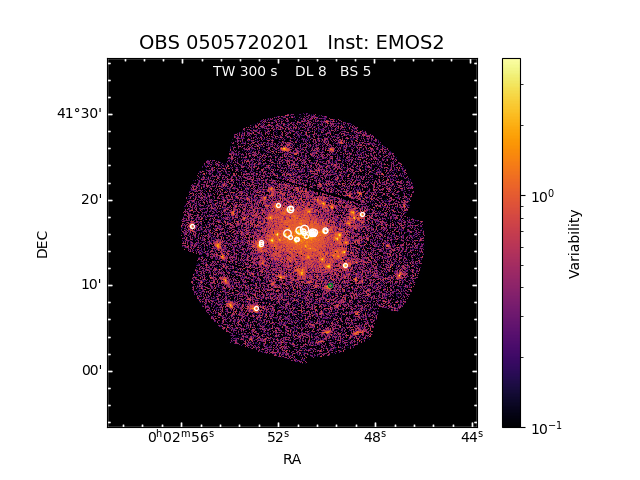

Text(0.5, 0.95, 'TW 300 s    DL 8   BS 5')

In [407]:
# Plotting the variability data
%matplotlib notebook
plt.subplot(111, projection=w)

im = plt.imshow(data, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)

ax = plt.gca()
ax.set_facecolor('k')
cbar = plt.colorbar(im)

# Plotting the sources
if len(src) != 0 :
    # Position of the sources
    for s in src:
        plt.plot(s['X'], s['Y'], 'wo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=1)
        if header['INSTRUME']=='EPN':
            if s['ID'] in np.append(np.array(corr_PN_M1['ID_1']),np.array(corr_PN_M2['ID_1'])):
                plt.plot(s['X'], s['Y'], 'bo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=2)
            for j in range(len(src_triple)):
                if s['ID']==src_triple[j][0]:
                    plt.plot(s['X'], s['Y'], 'go', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=3)
        elif header['INSTRUME']=='EMOS1':
            if s['ID'] in np.append(np.array(corr_PN_M1['ID_2']),np.array(corr_M1_M2['ID_1'])):
                plt.plot(s['X'], s['Y'], 'bo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=2)
            for j in range(len(src_triple)):
                if s['ID']==src_triple[j][2]:
                    plt.plot(s['X'], s['Y'], 'go', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=3)
        elif header['INSTRUME']=='EMOS2':
            if s['ID'] in np.append(np.array(corr_M1_M2['ID_2']),np.array(corr_PN_M2['ID_2'])):
                plt.plot(s['X'], s['Y'], 'bo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=2)
            for j in range(len(src_triple)):
                if s['ID']==src_triple[j][4]:
                    plt.plot(s['X'], s['Y'], 'go', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=3)
        

ra  = ax.coords[0]
dec = ax.coords[1]

ra.display_minor_ticks(True)
dec.display_minor_ticks(True)
ax.tick_params(axis='both', which='both', direction='in', color='w', width=1)

# Labels
plt.xlabel('RA', fontsize=10)
plt.ylabel('DEC', fontsize=10)
cbar.ax.set_ylabel('Variability', fontsize=10)

# Title
plt.title('OBS {0}   Inst: {1}'.format(header['OBS_ID'], header['INSTRUME']), fontsize=14)
plt.text(0.5, 0.95, "TW {0} s    DL {1}   BS {2}".format(tw, dl, bs), color='white', fontsize=10, horizontalalignment='center', transform = ax.transAxes)

#### Test

In [144]:
2 in np.append(np.array(corr_PN_M1['ID_1']),np.array(corr_PN_M2['ID_1']))

False

In [153]:
src_triple

[[6, 'PN', 1, 'M1', 1, 'M2']]

In [157]:
src_triple[0][4]

1

In [11]:
sources_all

NameError: name 'sources_all' is not defined